In [0]:
!pip install tensorflow==2.0.0

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0


# Gradient Tape

Gradient Tape is used to compute gradients and observe the variables using the .watch() method

In [10]:
a = tf.random.normal(shape=(2, 2))
b = tf.random.normal(shape=(2, 2))

with tf.GradientTape() as tape:
  tape.watch(a)
  c = tf.sqrt(tf.square(a) + tf.square(b))

  dc_da = tape.gradient(c, a)
  print(dc_da)

tf.Tensor(
[[-0.01292065  0.71132344]
 [ 0.982989   -0.82440245]], shape=(2, 2), dtype=float32)


# Computing higher order derivatives by nesting tapes

In [11]:
a = tf.Variable(a)
b = tf.Variable(b)

with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as inner_tape:

    c = tf.sqrt(tf.square(a) + tf.square(b))

    dc_da = inner_tape.gradient(c, a)
  
  dc2_da2 = outer_tape.gradient(c, a)

print(dc_da, dc2_da2)


tf.Tensor(
[[-0.01292065  0.71132344]
 [ 0.982989   -0.82440245]], shape=(2, 2), dtype=float32) tf.Tensor(
[[-0.01292065  0.71132344]
 [ 0.982989   -0.82440245]], shape=(2, 2), dtype=float32)


# Linear Regression from Scratch

In [0]:
input_dim = 2
output_dim = 1
learning_rate = 0.01

# This is our weight matrix
w = tf.Variable(tf.random.uniform(shape=(input_dim, output_dim)))
# This is our bias vector
b = tf.Variable(tf.zeros(shape=(output_dim,)))

def compute_predictions(features):
  return tf.matmul(features, w) + b

def compute_loss(labels, predictions):
  return tf.reduce_mean(tf.square(labels - predictions))

def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = compute_predictions(x)
    loss = compute_loss(y, predictions)
    # Note that `tape.gradient` works with a list as well (w, b).
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss

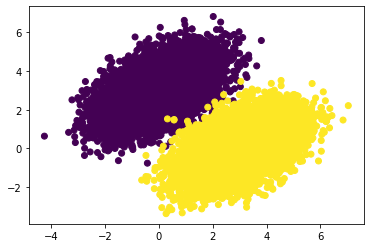

In [15]:
# Prepare a dataset.
num_samples = 10000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5],[0.5, 1]], size=num_samples)
features = np.vstack((negative_samples, positive_samples)).astype(np.float32)
labels = np.vstack((np.zeros((num_samples, 1), dtype='float32'),
                    np.ones((num_samples, 1), dtype='float32')))

plt.scatter(features[:, 0], features[:, 1], c=labels[:, 0])

In [19]:
#TRAINING OUR MODEL

indices = np.random.permutation(len(features))
features = features[indices]
labels = labels[indices]

dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(256)

print(dataset)

<BatchDataset shapes: ((None, 2), (None, 1)), types: (tf.float32, tf.float32)>


In [24]:
for epoch in range(10):
  for step, (x, y) in enumerate(dataset):
    loss = train_on_batch(x, y)
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Epoch 0: last batch loss = 0.0626
Epoch 1: last batch loss = 0.0440
Epoch 2: last batch loss = 0.0348
Epoch 3: last batch loss = 0.0358
Epoch 4: last batch loss = 0.0284
Epoch 5: last batch loss = 0.0368
Epoch 6: last batch loss = 0.0162
Epoch 7: last batch loss = 0.0266
Epoch 8: last batch loss = 0.0207
Epoch 9: last batch loss = 0.0254


# tf.function decorator

This compiles the function as a  static graph and gives us a nice computation speedup

In [0]:
@tf.function
def train_on_batch(x, y):
  with tf.GradientTape() as tape:
    predictions = compute_predictions(x)
    loss = compute_loss(y, predictions)
    # Note that `tape.gradient` works with a list as well (w, b).
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
  w.assign_sub(learning_rate * dloss_dw)
  b.assign_sub(learning_rate * dloss_db)
  return loss